/var/folders/y6/36h2pwl51ql85zwkh35jmm1r0000gp/T/ipykernel_99830/3632018494.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test =row[4]+ (np.random.rand()+0.1)/10
/var/folders/y6/36h2pwl51ql85zwkh35jmm1r0000gp/T/ipykernel_99830/3632018494.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test2 =row[7]+ (np.random.rand()+0.2)/10
/var/folders/y6/36h2pwl51ql85zwkh35jmm1r0000gp/T/ipykernel_99830/3632018494.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by 

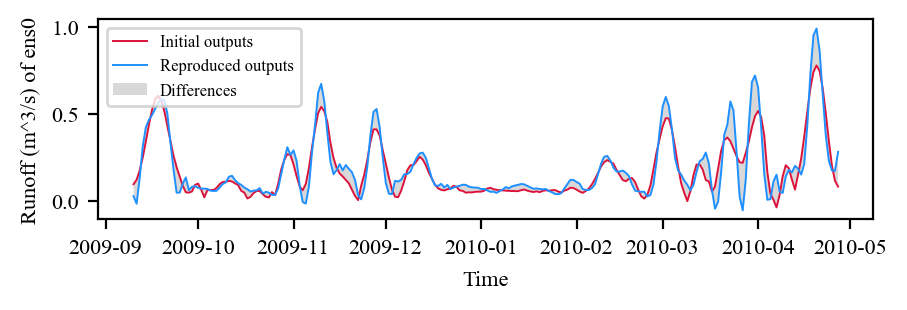

In [74]:

##------------------Fig 2----------------

import matplotlib.pyplot as plt
from openpyxl import load_workbook
# import xlrd
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
%matplotlib inline
import math
from scipy.interpolate import make_interp_spline
from scipy.signal import savgol_filter


table = pd.read_excel('./case-comparison.xlsx',sheet_name="Sheet1")
# print("table",table)

for index, row in table.iterrows():    
    test=0
    test2=0
    test =row[4]+ (np.random.rand()+0.1)/10
    test2 =row[7]+ (np.random.rand()+0.2)/10    
    table.loc[index,11] = round(test,2)
    table.loc[index,12] = round(test2,2)
x_data = table.iloc [50:280, 0]
y1 = table.iloc[50:280,11]
y = table.iloc[50:280,12]

y_initial = savgol_filter(y1, 30, 8, mode= 'nearest')
y_reproduced = savgol_filter(y, 20, 9, mode= 'nearest')

plt.figure(figsize=(5,2),dpi=200)
# plt.gcf().subplots_adjust(left=0,top=0.1,bottom=0, right=0.1)
plt.gcf().subplots_adjust(top=0.8,bottom=0.3,)
plt.rcParams['font.size'] = 8
plt.rcParams['font.family']='Times New Roman'
plt.plot(x_data,y_initial, color='crimson',linewidth=0.7, label='Reproduced outputs',linestyle='-')
plt.plot(x_data,y_reproduced,color='dodgerblue',linewidth=0.7, label='Original outputs',linestyle='-')

plt.xticks(rotation=0)
plt.fill_between(x_data, y_initial, y_reproduced, facecolor='grey', alpha=0.3)
plt.legend(["Initial outputs", "Reproduced outputs", "Differences"],loc="upper left", ncol=1, prop={"family": "Times New Roman", "size": 6})

plt.rcParams['axes.facecolor'] = 'white'
plt.grid(False)  # 添加网格，true 首字母大写
plt.axis(True)
ax=plt.gca()
ax.spines['bottom'].set_color('black') 
ax.spines['left'].set_color('black') 
ax.spines['right'].set_color('black') 
ax.spines['top'].set_color('black') 
# ax.axes.labelsize
ax.xaxis.label.set_color('black') 
ax.tick_params(axis='x', colors='black')
ax.set_xlabel('Time')
ax.set_ylabel('Runoff (m^3/s) of ens0')
    
plt.savefig('test.svg')


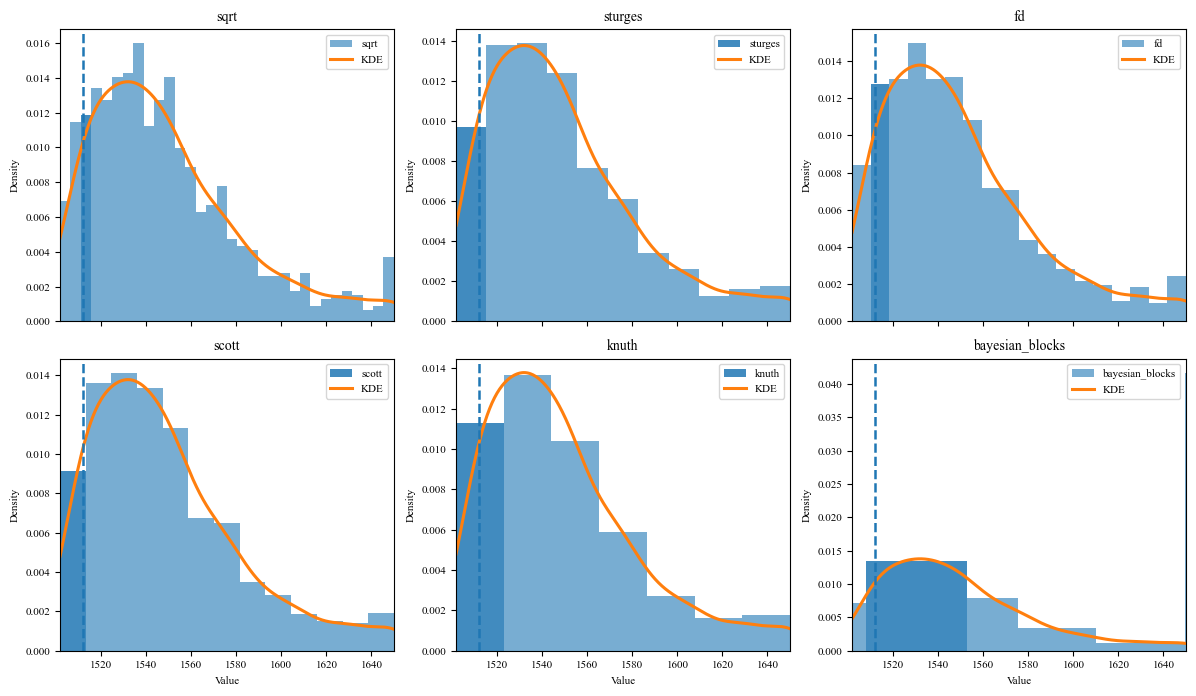

In [75]:
##------------------Fig 6----------------
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from astropy.stats import knuth_bin_width, bayesian_blocks

# -----------------------------
# 1) Same data for all methods
# -----------------------------
rng = np.random.default_rng(42)
N = 1000
a, b = 1500, 1650

y = a + rng.gamma(shape=2.0, scale=25.0, size=N)
y = np.clip(y, a, b)

y0 = 1512.0  # original value (vertical dashed line)

# -----------------------------
# 2) Bin-edge calculators
# -----------------------------
def edges_sqrt(data):
    k = int(np.ceil(np.sqrt(len(data))))
    return np.histogram_bin_edges(data, bins=k)

def edges_sturges(data):
    k = int(np.ceil(np.log2(len(data)) + 1))
    return np.histogram_bin_edges(data, bins=k)

def edges_fd(data):
    q25, q75 = np.percentile(data, [25, 75])
    iqr = q75 - q25
    n = len(data)
    if iqr == 0:
        return np.histogram_bin_edges(data, bins="auto")
    h = 2 * iqr * (n ** (-1/3))
    k = int(np.ceil((data.max() - data.min()) / h)) if h > 0 else 1
    return np.histogram_bin_edges(data, bins=max(k, 1))

def edges_scott(data):
    n = len(data)
    sigma = np.std(data, ddof=1)
    if sigma == 0:
        return np.histogram_bin_edges(data, bins="auto")
    h = 3.5 * sigma * (n ** (-1/3))
    k = int(np.ceil((data.max() - data.min()) / h)) if h > 0 else 1
    return np.histogram_bin_edges(data, bins=max(k, 1))

def edges_knuth(data):
    width = knuth_bin_width(data, return_bins=False)
    if not np.isfinite(width) or width <= 0:
        return np.histogram_bin_edges(data, bins="auto")
    k = int(np.ceil((data.max() - data.min()) / width))
    return np.histogram_bin_edges(data, bins=max(k, 1))

def edges_bayesian_blocks(data):
    return bayesian_blocks(data, fitness="events", p0=0.05)

methods = [
    ("sqrt", edges_sqrt),
    ("sturges", edges_sturges),
    ("fd", edges_fd),
    ("scott", edges_scott),
    ("knuth", edges_knuth),
    ("bayesian_blocks", edges_bayesian_blocks),
]

# -----------------------------
# 3) Plot helper
# -----------------------------
def plot_hist_kde(ax, data, edges, title, y0=None):
    hist_vals, bin_edges, patches = ax.hist(
        data, bins=edges, density=True, alpha=0.60, label=title
    )

    xs = np.linspace(np.min(data), np.max(data), 400)
    kde = gaussian_kde(data)
    ax.plot(xs, kde(xs), linewidth=2.2, label="KDE")

    if y0 is not None:
        ax.axvline(y0, linestyle="--", linewidth=1.8)
        idx = np.searchsorted(bin_edges, y0, side="right") - 1
        if 0 <= idx < len(patches):
            patches[idx].set_alpha(0.85)

    ax.set_title(title, fontsize=10)
    ax.set_ylabel("Density")
    ax.legend(fontsize=8, frameon=True)

# -----------------------------
# 4) 2x3 comparison figure (shared x-axis)
# -----------------------------
fig, axes = plt.subplots(2, 3, figsize=(12, 7), sharex=True)
axes = axes.ravel()

# Fix x-limits so all panels align perfectly
xmin, xmax = y.min(), y.max()

for ax, (name, edge_fn) in zip(axes, methods):
    edges = edge_fn(y)
    plot_hist_kde(ax, y, edges, title=name, y0=y0)
    ax.set_xlim(xmin, xmax)

# Only bottom row shows x-axis tick labels + x label
for i, ax in enumerate(axes):
    if i < 3:  # top row
        ax.tick_params(labelbottom=False)  # hide x tick labels
        ax.set_xlabel("")
    else:      # bottom row
        ax.set_xlabel("Value")

# fig.suptitle("Frequency Distribution and KDE (Same Data, Different Binning Rules)", fontsize=12)
plt.tight_layout()
plt.show()

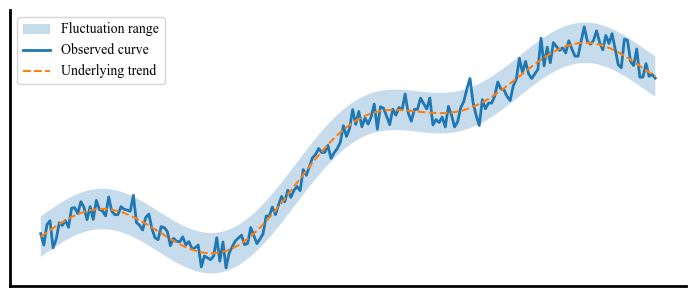

In [76]:
##------------------Fig 7----------------

import numpy as np
import matplotlib.pyplot as plt

# --- Data (example) ---
rng = np.random.default_rng(42)
x = np.linspace(0, 10, 200)

trend = 0.25 + 0.25 * np.tanh((x - 5) / 1.6) + 0.08 * np.sin(1.6 * x)
# trend =  0.1 * np.tanh((x - 5) / 1.8) + 0.01 * np.sin(1.6 * x)

y = trend + rng.normal(0, 0.03, size=x.size)

sigma = 0.03
lower = trend - 2 * sigma
upper = trend + 2 * sigma

threshold = 0.65

# --- Plot ---
fig, ax = plt.subplots(figsize=(7, 3))

ax.fill_between(x, lower, upper, alpha=0.25, label="Fluctuation range")
ax.plot(x, y, linewidth=2, label="Observed curve")
ax.plot(x, trend, linestyle="--", label="Underlying trend")
# ax.axhline(threshold, linestyle=":", label="Threshold")

# ax.set_xlabel("x")
# ax.set_ylabel("y")
# ax.set_title("Curve with Threshold and Fluctuation Range")
ax.legend(fontsize=10)

# Hide axis numbers (no tick labels)
ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

# Keep only left & bottom spines (axes lines)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Thicken left & bottom spines
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_linewidth(2)

# Transparent background
fig.patch.set_alpha(0)
ax.set_facecolor("none")
plt.tight_layout()
plt.show()

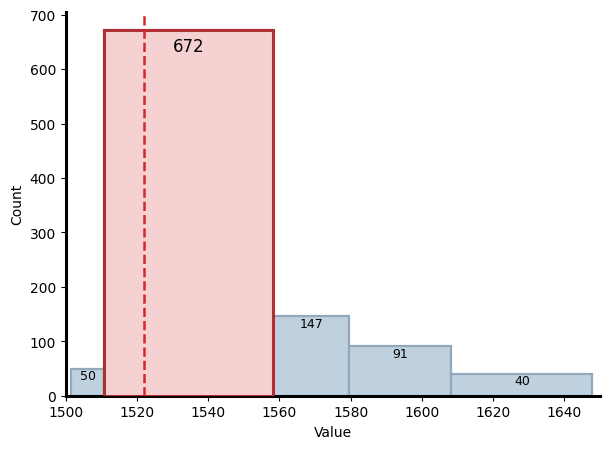

In [2]:
##------------------Fig 8----------------

import numpy as np
import matplotlib.pyplot as plt
from astropy.stats import bayesian_blocks
from matplotlib.patches import Rectangle

rng = np.random.default_rng(2026)
N = 1000
a, b = 1500, 1650

# --- Truncated sampling instead of clip (avoid boundary pile-up) ---
y = []
while len(y) < N:
    cand = a + rng.gamma(shape=2.2, scale=22.0, size=N)
    cand = cand[(cand >= a) & (cand <= b)]
    y.extend(cand.tolist())
y = np.array(y[:N])

y0 = 1522.0

# Bayesian Blocks edges
edges = bayesian_blocks(y, fitness="events", p0=0.05)

# --- Colors ---
bar_fill = "#BFD0DE"
bar_edge = "#93A9BB"

highlight_fill = "#FAD2D2"
highlight_edge = "#AD282A"

fig, ax = plt.subplots(figsize=(6.2, 4.6))

# ---- COUNT histogram (density=False) ----
hist_vals, bin_edges, patches = ax.hist(
    y,
    bins=edges,
    density=False,          # <-- Count
    alpha=1.0,
    color=bar_fill,
    edgecolor=bar_edge,
    linewidth=1.6,
    label="Bayesian blocks"
)

# Annotate count on each bin (integer)
for i, h in enumerate(hist_vals):
    if h <= 0:
        continue
    x_center = 0.5 * (bin_edges[i] + bin_edges[i + 1])
    ax.text(x_center, h * 0.98, f"{int(h)}", ha="center", va="top", fontsize=9)

# ---- highlight the bin containing y0 with a full-width rectangle ----
idx = np.searchsorted(bin_edges, y0, side="right") - 1
if 0 <= idx < len(hist_vals):
    x_left  = bin_edges[idx]
    x_right = bin_edges[idx + 1]
    width = x_right - x_left
    height = hist_vals[idx]  # <-- Count height

    rect = Rectangle(
        (x_left, 0), width, height,
        facecolor=highlight_fill,
        edgecolor=highlight_edge,
        linewidth=2.2,
        alpha=0.95,
        zorder=5
    )
    ax.add_patch(rect)
        # re-draw the count label on top of the highlighted (pink) bin
    ax.text(
        (x_left + x_right) / 2,
        height * 0.98,
        f"{int(height)}",
        ha="center",
        va="top",
        fontsize=12,
        zorder=7
    )

# y0 vertical line (red)
ax.axvline(y0, linestyle="--", linewidth=1.8, color="#d62728", label="y0", zorder=6)

ax.set_xlim(a, b)
ax.set_xlabel("Value")
ax.set_ylabel("Count")

# Only keep left & bottom spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(2.2)
ax.spines["bottom"].set_linewidth(2.2)
# ax.text(x_center, h * 0.98, f"{int(h)}", ha="center", va="top", fontsize=9, zorder=7)
# ax.legend(fontsize=10, frameon=True)

plt.tight_layout()
plt.show()

/Users/mimi/miniconda3/envs/pip39/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


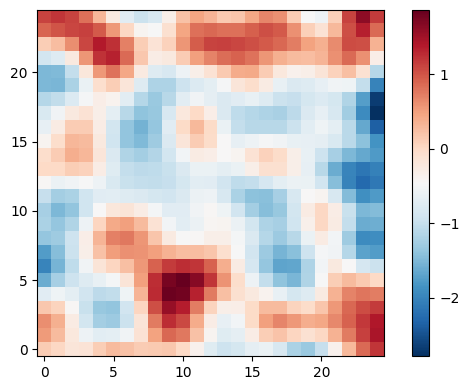

In [7]:

##------------------Fig 12----------------


import numpy as np
import pandas as pd
import gstools as gs
from sklearn.preprocessing import KBinsDiscretizer
from hmmlearn import hmm
import matplotlib.pyplot as plt

# 定义数据维度
dimensionxy = 25

# 生成数据
x = np.linspace(0, 25, 25)
y = np.linspace(0, 25, 25)
XX, YY = np.meshgrid(x, y)

# 第一个数据
model = gs.Gaussian(dim=2, var=1, len_scale=3)
srf = gs.SRF(model, mean=0.)
srf((x, y), mesh_type='structured')
B0 = srf((x, y), mesh_type='structured', seed=100)

# 定义状态数
n_states = 5
est = KBinsDiscretizer(n_bins=n_states, encode='ordinal', strategy='uniform')
B_discretized = est.fit_transform(B0).astype(int)


# # 可视化
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

# 原始随机场带噪声
im0 = axes.imshow(B0, origin='lower', cmap='RdBu_r')
# axes.set_title('Initial with Noise')
fig.colorbar(im0, ax=axes)


plt.tight_layout()
plt.show()
